In [2]:
from cs592_proj.moritz_testing.generate_ranked_trajectories import generate_policies_and_videos, generate_trajectories, record_trajectory_video 
import numpy as np

ENV_NAME = "CartPole-v1"
ITERATION_STEP = 1000
NUM_POLICIES = 10

video_entries, policy_entries = generate_policies_and_videos(NUM_POLICIES, ITERATION_STEP, ENV_NAME)
trajectory_entries = generate_trajectories(policy_entries[0:len(policy_entries)//2], ENV_NAME, no_trajectories=10)

for i in range(0, len(trajectory_entries)):
    print(trajectory_entries[i].rews.shape) # why is reward capped at 500 ? 

print(len(trajectory_entries))


ModuleNotFoundError: No module named 'stable_baselines3'

In [6]:
def make_fragments(traj, frag_len=25, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    T = len(traj.obs) - 1  # last obs has no action
    if T < frag_len: return []
    starts = rng.integers(0, T - frag_len + 1, size=max(1, T // frag_len))
    return [(traj.obs[s:s+frag_len], traj.rews) for s in starts]

def make_ranked_pairs(trajs, n_pairs=20000, frag_len=25, rng=None, tie_margin=0.0):
    rng = np.random.default_rng() if rng is None else rng
    # flatten all fragments
    frags = []
    for tr in trajs:
        frags += make_fragments(tr, frag_len, rng)
        print(len(frags))
    frags = [(o.astype(np.float32), r.astype(np.float32)) for o,r in frags]
    # sample pairs + label by true return
    pairs = []
    for _ in range(min(n_pairs, len(frags)**2)):
        i, j = rng.integers(0, len(frags), size=2)
        (o1, r1), (o2, r2) = frags[i], frags[j]
        g1, g2 = float(r1.sum()), float(r2.sum())
        if abs(g1-g2) <= tie_margin: continue
        y = 1.0 if g1 > g2 else 0.0
        pairs.append((o1, o2, y))
    return pairs

In [7]:
pairs = []
pairs = make_ranked_pairs(trajectory_entries)
print(len(pairs))

2
4
6
8
14
19
23
25
27
28
33
38
42
47
52
59
64
68
73
78
90
95
102
112
120
126
138
148
154
164
184
201
210
230
238
258
268
280
300
320
337
352
359
366
372
379
389
409
429
448
17758


In [8]:

#TODO: add collatefn to add padding (or do it ealier)

from torch.utils.data import Dataset, DataLoader, random_split
import torch

def collate_pad(batch):
    # pad sequences to same T (left pad=False → right pad with zeros)
    o1s, o2s, ys = zip(*batch)
    T1 = max(x.shape[0] for x in o1s); T2 = max(x.shape[0] for x in o2s)
    def pad(stack, T):
        D = stack[0].shape[1]
        out = torch.zeros(len(stack), T, D)
        for i,x in enumerate(stack):
            out[i,:x.shape[0]] = x
        return out
    return pad(o1s, T1), pad(o2s, T2), torch.stack(ys)

class PrefPairsDS(Dataset):
    def __init__(self, pairs): self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        o1, o2, y = self.pairs[i]               # (T, obs_dim), (T, obs_dim), scalar
        return torch.from_numpy(o1), torch.from_numpy(o2), torch.tensor(y, dtype=torch.float32)

pairs_dataset = PrefPairsDS(pairs)
val_fraction = 0.2
val_size = max(1, int(len(pairs_dataset) * val_fraction))
train_size = len(pairs_dataset) - val_size
if train_size <= 0:
    raise ValueError('Not enough preference pairs to create a training split.')
generator = torch.Generator().manual_seed(0)
train_dataset, val_dataset = random_split(pairs_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_pad)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_pad)


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

obs_dim = gym.make(ENV_NAME).observation_space.shape[0]

class RewardMLP(nn.Module):
    def __init__(self, obs_dim, hid=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid), nn.Tanh(),
            nn.Linear(hid, hid), nn.Tanh(),
            nn.Linear(hid, 1)
        )
    def forward(self, x):            # x: (B, D)
        return self.net(x).squeeze(-1)

reward_net = RewardMLP(obs_dim)
opt = torch.optim.Adam(reward_net.parameters(), lr=3e-4)
device = torch.device("cpu"); reward_net.to(device)

def pred_frag_return(obs_seq):       # (B, T, D) -> (B,)
    B,T,D = obs_seq.shape
    r = reward_net(obs_seq.reshape(B*T, D)).view(B,T).sum(dim=1)
    return r

def bt_loss(r1, r2, y):              # y in {0,1}
    return F.binary_cross_entropy_with_logits(r1 - r2, y)



In [10]:

import matplotlib.pyplot as plt

num_epochs = 30
train_losses, val_losses = [], []

def run_epoch(data_loader, train=True):
    reward_net.train(mode=train)
    total_loss, n_batches = 0.0, 0
    context = torch.enable_grad() if train else torch.no_grad()
    with context:
        for o1, o2, y in data_loader:
            o1, o2, y = o1.to(device), o2.to(device), y.to(device)
            T = min(o1.shape[1], o2.shape[1])
            o1, o2 = o1[:, :T], o2[:, :T]
            r1, r2 = pred_frag_return(o1), pred_frag_return(o2)
            loss = bt_loss(r1, r2, y)
            if train:
                opt.zero_grad(); loss.backward()
                nn.utils.clip_grad_norm_(reward_net.parameters(), 5.0)
                opt.step()
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:02d}/{num_epochs}  train_loss={train_loss:.4f}  val_loss={val_loss:.4f}")


Epoch 01/30  train_loss=0.6088  val_loss=0.5785
Epoch 02/30  train_loss=0.5599  val_loss=0.5437
Epoch 03/30  train_loss=0.5278  val_loss=0.5214
Epoch 04/30  train_loss=0.5121  val_loss=0.5039
Epoch 05/30  train_loss=0.4933  val_loss=0.5011
Epoch 06/30  train_loss=0.4855  val_loss=0.4948
Epoch 07/30  train_loss=0.4804  val_loss=0.4765
Epoch 08/30  train_loss=0.4724  val_loss=0.4913
Epoch 09/30  train_loss=0.4659  val_loss=0.4741
Epoch 10/30  train_loss=0.4624  val_loss=0.4613
Epoch 11/30  train_loss=0.4545  val_loss=0.4527
Epoch 12/30  train_loss=0.4504  val_loss=0.4556
Epoch 13/30  train_loss=0.4415  val_loss=0.4466
Epoch 14/30  train_loss=0.4379  val_loss=0.4433
Epoch 15/30  train_loss=0.4343  val_loss=0.4315
Epoch 16/30  train_loss=0.4276  val_loss=0.4346
Epoch 17/30  train_loss=0.4256  val_loss=0.4347
Epoch 18/30  train_loss=0.4188  val_loss=0.4272
Epoch 19/30  train_loss=0.4181  val_loss=0.4194
Epoch 20/30  train_loss=0.4115  val_loss=0.4145
Epoch 21/30  train_loss=0.4086  val_loss

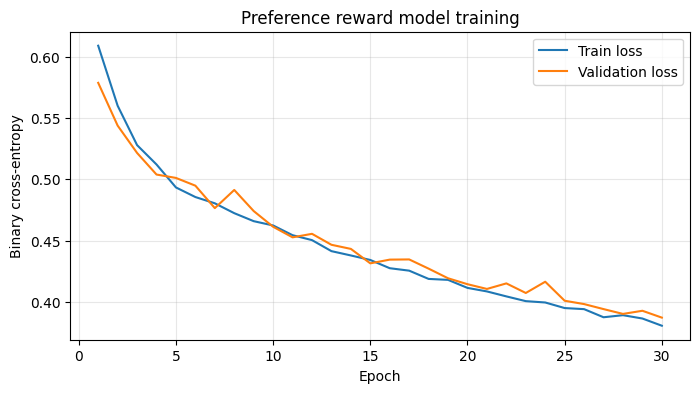

In [11]:

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Binary cross-entropy')
plt.title('Preference reward model training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Affine alignment: pred ≈ 0.382 * true + -24.249; applying inverse transform.


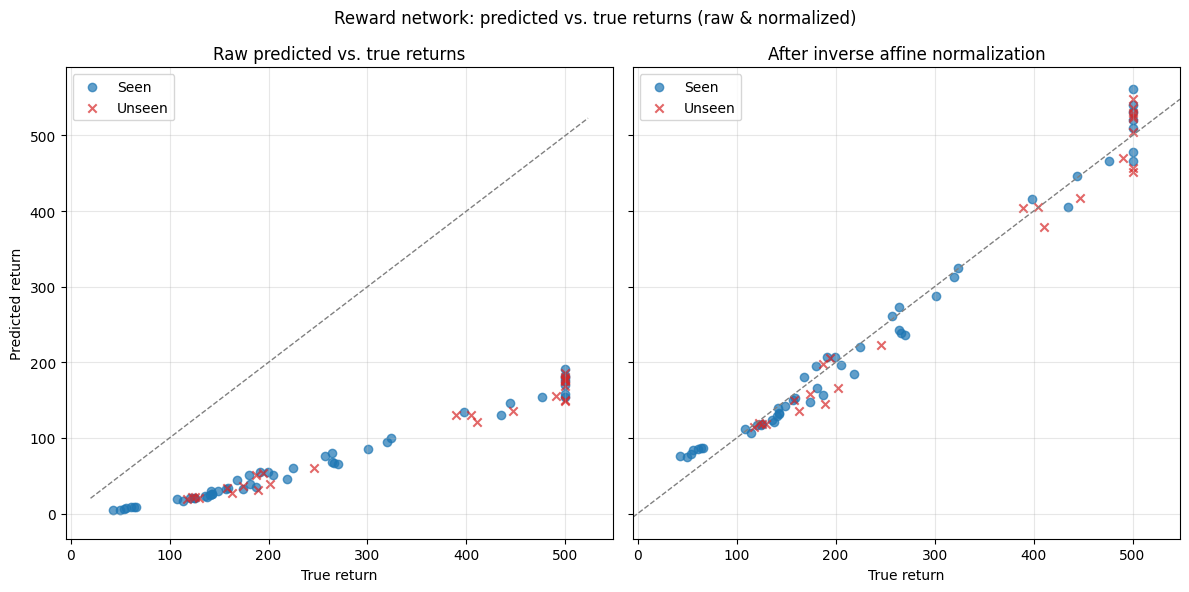

In [14]:

import torch
import matplotlib.pyplot as plt

# Compare predicted vs. true returns on seen and unseen trajectories,
# then normalize predicted rewards via the inverse affine transform.

def evaluate_trajectory(traj):
    obs = torch.from_numpy(traj.obs.astype(np.float32)).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = pred_frag_return(obs).item()
    true = float(traj.rews.sum())
    return true, pred

seen_stats = [evaluate_trajectory(entry) for entry in trajectory_entries]

# Generate a small batch of trajectories from policies not used for training pairs
unseen_policy_entries = policy_entries[2:len(policy_entries)//2+2]
unseen_entries = generate_trajectories(unseen_policy_entries, ENV_NAME, no_trajectories=5)
unseen_stats = [evaluate_trajectory(entry) for entry in unseen_entries]

true_seen = np.array([s[0] for s in seen_stats], dtype=np.float32)
pred_seen = np.array([s[1] for s in seen_stats], dtype=np.float32)
if len(true_seen) >= 2:
    slope, intercept = np.polyfit(true_seen, pred_seen, 1)
else:
    slope, intercept = 1.0, 0.0
if abs(slope) < 1e-8:
    slope = 1.0  # fallback to avoid division by zero

def normalize(stats):
    return [(true, (pred - intercept) / slope) for true, pred in stats]

normalized_seen = normalize(seen_stats)
normalized_unseen = normalize(unseen_stats)

print(f"Affine alignment: pred ≈ {slope:.3f} * true + {intercept:.3f}; applying inverse transform.")

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
for subset, stats, color in [("Seen", seen_stats, 'tab:blue'),
                             ("Unseen", unseen_stats, 'tab:red')]:
    if stats:
        ax[0].scatter(*zip(*stats), label=subset, alpha=0.7, marker='o' if subset == "Seen" else 'x', color=color)
ax[0].plot(ax[0].get_xlim(), ax[0].get_xlim(), '--', color='gray', linewidth=1)
ax[0].set_title('Raw predicted vs. true returns')
ax[0].set_xlabel('True return')
ax[0].set_ylabel('Predicted return')
ax[0].grid(True, alpha=0.3)
ax[0].legend()

for subset, stats, color in [("Seen", normalized_seen, 'tab:blue'),
                             ("Unseen", normalized_unseen, 'tab:red')]:
    if stats:
        ax[1].scatter(*zip(*stats), label=subset, alpha=0.7, marker='o' if subset == "Seen" else 'x', color=color)
lims = ax[1].get_xlim()
ax[1].plot(lims, lims, '--', color='gray', linewidth=1)
ax[1].set_xlim(lims)
ax[1].set_title('After inverse affine normalization')
ax[1].set_xlabel('True return')
ax[1].grid(True, alpha=0.3)
ax[1].legend()

plt.suptitle('Reward network: predicted vs. true returns (raw & normalized)')
plt.tight_layout()
plt.show()


/home/mzoellner/Projects/purdue/imitation-learning/imitation/.pixi/envs/default/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step3333 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step3333/ppo_learned_reward_step3333-episode-0.mp4.
MoviePy - Writing video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step3333/ppo_learned_reward_step3333-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step3333/ppo_learned_reward_step3333-episode-0.mp4


/home/mzoellner/Projects/purdue/imitation-learning/imitation/.pixi/envs/default/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step7500 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step7500/ppo_learned_reward_step7500-episode-0.mp4.
MoviePy - Writing video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step7500/ppo_learned_reward_step7500-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step7500/ppo_learned_reward_step7500-episode-0.mp4


/home/mzoellner/Projects/purdue/imitation-learning/imitation/.pixi/envs/default/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step11666 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step11666/ppo_learned_reward_step11666-episode-0.mp4.
MoviePy - Writing video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step11666/ppo_learned_reward_step11666-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step11666/ppo_learned_reward_step11666-episode-0.mp4


/home/mzoellner/Projects/purdue/imitation-learning/imitation/.pixi/envs/default/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step15833 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step15833/ppo_learned_reward_step15833-episode-0.mp4.
MoviePy - Writing video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step15833/ppo_learned_reward_step15833-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step15833/ppo_learned_reward_step15833-episode-0.mp4


/home/mzoellner/Projects/purdue/imitation-learning/imitation/.pixi/envs/default/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step20000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step20000/ppo_learned_reward_step20000-episode-0.mp4.
MoviePy - Writing video /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step20000/ppo_learned_reward_step20000-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/mzoellner/Projects/purdue/imitation-learning/imitation/src/imitation/moritz_testing/videos/ppo_learned_reward_step20000/ppo_learned_reward_step20000-episode-0.mp4


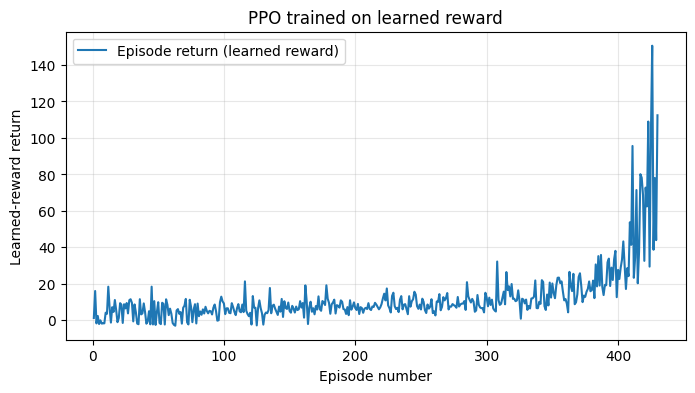

In [17]:

import gymnasium as gym
from pathlib import Path

import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback

from imitation.moritz_testing.generate_ranked_trajectories import record_video

reward_net.eval()

class LearnedRewardEnv(gym.Wrapper):
    """Wraps env to replace rewards with learned reward network outputs."""
    def __init__(self, env, reward_model):
        super().__init__(env)
        self.reward_model = reward_model

    def step(self, action):
        obs, true_reward, terminated, truncated, info = self.env.step(action)
        obs_tensor = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            learned_reward = self.reward_model(obs_tensor).item()
        info = dict(info)
        info.setdefault('true_reward', true_reward)
        return obs, learned_reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class VideoAndRewardCallback(BaseCallback):
    def __init__(self, env_name, record_steps, video_dir=Path('videos') / 'ppo_learned_reward', **kwargs):
        super().__init__(**kwargs)
        self.env_name = env_name
        self.video_dir = Path(video_dir)
        self.episode_returns = []
        self.episode_indices = []
        self._episode_count = 0
        self.record_steps = iter(record_steps)
        self.next_record_step = next(self.record_steps, None)

    def _init_callback(self):
        self.video_dir.mkdir(parents=True, exist_ok=True)

    def _on_step(self):
        infos = self.locals.get('infos', [])
        for info in infos:
            episode_info = info.get('episode')
            if episode_info is not None:
                self._episode_count += 1
                self.episode_indices.append(self._episode_count)
                self.episode_returns.append(episode_info['r'])
        while self.next_record_step is not None and self.num_timesteps >= self.next_record_step:
            record_video(
                env_name=self.env_name,
                policy=self.model,
                file_name=f'ppo_learned_reward_step{self.next_record_step}',
                deterministic=True,
                debug=False,
            )
            self.next_record_step = next(self.record_steps, None)
        return True

learned_reward_timesteps = 20000
record_steps = np.linspace(
    learned_reward_timesteps / 6,
    learned_reward_timesteps,
    num=5,
    dtype=int,
)
video_callback = VideoAndRewardCallback(ENV_NAME, record_steps=record_steps)

def make_env():
    base_env = gym.make(ENV_NAME)
    return LearnedRewardEnv(base_env, reward_net)

ppo_model = PPO('MlpPolicy', make_env(), verbose=0, seed=0)
ppo_model.learn(total_timesteps=learned_reward_timesteps, callback=video_callback)

plt.figure(figsize=(8, 4))
plt.plot(video_callback.episode_indices, video_callback.episode_returns, label='Episode return (learned reward)')
plt.xlabel('Episode number')
plt.ylabel('Learned-reward return')
plt.title('PPO trained on learned reward')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
